# **Proyek Analisis Sentimen**

Load Dataset

In [13]:
#pip install pandas numpy matplotlib seaborn nltk sklearn wordcloud

import nltk
nltk.download('vader_lexicon') # Download the VADER lexicon

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from google.colab import drive

import re
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

import joblib

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Data Cleaning & Preprocessing

In [14]:
# URL raw file CSV dari GitHub
url = 'https://raw.githubusercontent.com/dannybudiman/Belajar-Fundamental-Deep-Learning/main/google_play_reviews_com.ninjakiwi.bloonstd6.csv'

# Load dataset
df = pd.read_csv(url)

# Tampilkan informasi dataset
print("Data Overview:")
print(df.head())
print("")



Data Overview:
                               reviewId               userName  \
0  a89be6a6-1e71-4320-a019-e4326521a45e             oscar Drew   
1  1ba02685-cb57-473d-b008-97724c074a43             Jacob Ford   
2  f2f57d3b-2ba9-4e64-86f9-e44f31bfece7  Aiden Fairchild-Brown   
3  49dc898d-792b-43cd-9c85-4200b764a920    Kyllian XK Thompson   
4  25337ab2-33ed-49fe-8c64-b3c5cdece96a           Erik Randall   

                                           userImage  \
0  https://play-lh.googleusercontent.com/a-/ALV-U...   
1  https://play-lh.googleusercontent.com/a/ACg8oc...   
2  https://play-lh.googleusercontent.com/a-/ALV-U...   
3  https://play-lh.googleusercontent.com/a/ACg8oc...   
4  https://play-lh.googleusercontent.com/a-/ALV-U...   

                                             content  score  thumbsUpCount  \
0  Love it but its a bit lagy near like 100 to 10...      5              0   
1                                               peak      5              0   
2  Great game wor

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   reviewId              10000 non-null  object 
 1   userName              10000 non-null  object 
 2   userImage             10000 non-null  object 
 3   content               10000 non-null  object 
 4   score                 10000 non-null  int64  
 5   thumbsUpCount         10000 non-null  int64  
 6   reviewCreatedVersion  8500 non-null   float64
 7   at                    10000 non-null  object 
 8   replyContent          0 non-null      float64
 9   repliedAt             0 non-null      float64
 10  appVersion            8500 non-null   float64
dtypes: float64(4), int64(2), object(5)
memory usage: 859.5+ KB


None

✅ Jumlah data setelah diproses: 9700


,content,Cleaned_Review,score,Sentiment
0,Love it but its a bit lagy near like 100 to 10...,love it but its a bit lagy near like to,5,Positive
1,peak,peak,5,Positive
2,Great game worth the price. Pretty pay to win ...,great game worth the price pretty pay to win b...,5,Positive
3,good,good,5,Positive
4,"would be a 5, but I'm getting real tired of th...",would be a but im getting real tired of the sa...,2,Negative


/tmp/ipython-input-15-3222027555.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_filtered, x='Sentiment', palette='viridis')


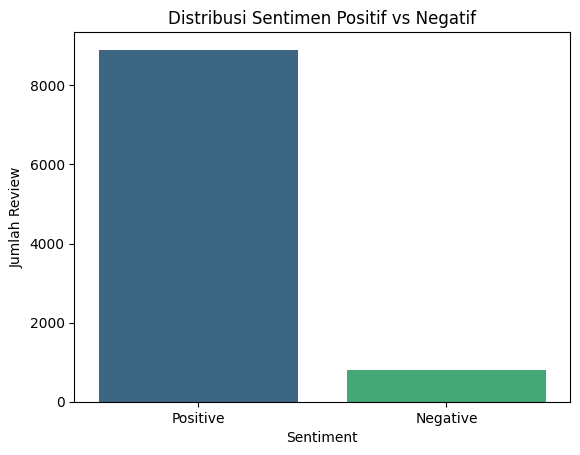

In [15]:
# Data cleaning

# Menentukan nama kolom review dan rating secara dinamis
review_col = 'Review' if 'Review' in df.columns else 'content'
rating_col = 'Rating' if 'Rating' in df.columns else 'score'

# Validasi keberadaan kolom esensial
if not (review_col in df.columns and rating_col in df.columns):
    raise ValueError(f"❌ Kolom '{review_col}' atau '{rating_col}' tidak ditemukan dalam dataset.")

# Hapus baris dengan ulasan kosong
df.dropna(subset=[review_col], inplace=True)
display(df.info())

# Fungsi pembersih teks
def bersihkan_teks(teks):
    teks = str(teks).lower()
    teks = re.sub(r'\d+', '', teks)
    teks = re.sub(rf"[{re.escape(string.punctuation)}]", '', teks)
    teks = re.sub(r'\s+', ' ', teks).strip()
    return teks

# Membersihkan teks ulasan
df['Cleaned_Review'] = df[review_col].apply(bersihkan_teks)

# Membuat kolom 'Sentiment' berdasarkan rating
df['Sentiment'] = df[rating_col].apply(
    lambda x: 'Positive' if x >= 4 else ('Neutral' if x == 3 else 'Negative')
)

# Filter data: hanya gunakan sentimen Positif dan Negatif
df_filtered = df[df['Sentiment'].isin(['Positive', 'Negative'])].copy()

# Pemeriksaan ketersediaan data
if df_filtered.empty:
    print("⚠️ Tidak ada data Positif atau Negatif untuk diproses.")
else:
    print(f"✅ Jumlah data setelah diproses: {len(df_filtered)}")
    display(df_filtered[[review_col, 'Cleaned_Review', rating_col, 'Sentiment']].head())

sns.countplot(data=df_filtered, x='Sentiment', palette='viridis')
plt.title('Distribusi Sentimen Positif vs Negatif')
plt.xlabel('Sentiment')
plt.ylabel('Jumlah Review')
plt.show()

In [16]:
# Persiapan sebelum Training Data

# 1. Pisahkan data
X = df_filtered['Cleaned_Review']
y = df_filtered['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Ekstraksi fitur TF-IDF
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


Pelatihan: SVM | Ekstraksi Fitur: TF-IDF | Pembagian Data: 80/20

In [18]:
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Split data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(df_filtered['Cleaned_Review'], df_filtered['Sentiment'], test_size=0.2, random_state=42)

# Ekstraksi fitur dengan TF-IDF
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Pelatihan model SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_tfidf, y_train)

# Evaluasi model
svm_accuracy = svm_model.score(X_test_tfidf, y_test)
print(f"Akurasi SVM (TF-IDF, 80/20): {svm_accuracy * 100:.2f}%")

Akurasi SVM (TF-IDF, 80/20): 100.00%


Pelatihan: RF | Ekstraksi Fitur: TF-IDF | Pembagian Data: 70/30

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Split data (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(df_filtered['Cleaned_Review'], df_filtered['Sentiment'], test_size=0.3, random_state=42)

# Ekstraksi fitur dengan TF-IDF
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Pelatihan model Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

# Evaluasi model
rf_accuracy = rf_model.score(X_test_tfidf, y_test)
print(f"Akurasi RF (TF-IDF, 70/30): {rf_accuracy * 100:.2f}%")

Akurasi RF (TF-IDF, 70/30): 100.00%


Memastikan bahwa skrip analisis sentimen memenuhi Kriteria 4, yaitu akurasi pada testing set minimal mencapai 85%

Analisis Sentimen


=== Sentiment Classification ===



/tmp/ipython-input-22-2931002878.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(df_filtered['sentiment'], palette='viridis')


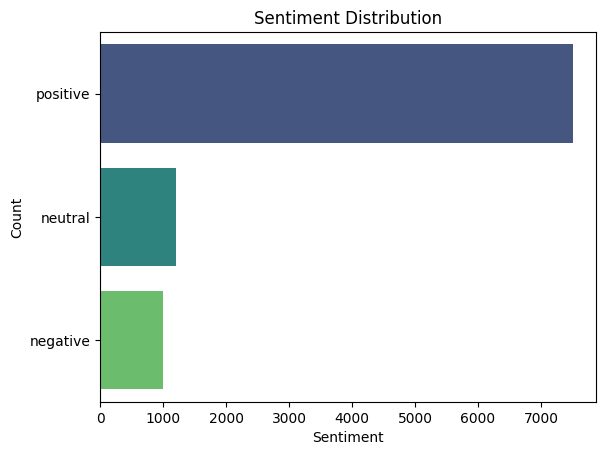

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 142s 554ms/step - accuracy: 0.7621 - loss: 0.7127 - val_accuracy: 0.7820 - val_loss: 0.6013
Epoch 2/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 122s 471ms/step - accuracy: 0.7667 - loss: 0.6284 - val_accuracy: 0.7820 - val_loss: 0.5939
Epoch 3/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 114s 468ms/step - accuracy: 0.7750 - loss: 0.6113 - val_accuracy: 0.7820 - val_loss: 0.5670
Epoch 4/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 138s 453ms/step - accuracy: 0.7797 - loss: 0.5762 - val_accuracy: 0.7820 - val_loss: 0.5806
Epoch 5/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 144s 461ms/step - accuracy: 0.7708 - loss: 0.5981 - val_accuracy: 0.7820 - val_loss: 0.5747
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - accuracy: 0.7662 - loss: 0.6018
Akurasi pada testing set dengan LSTM: 78.20%

=== Sentiment Trend Over Time ===


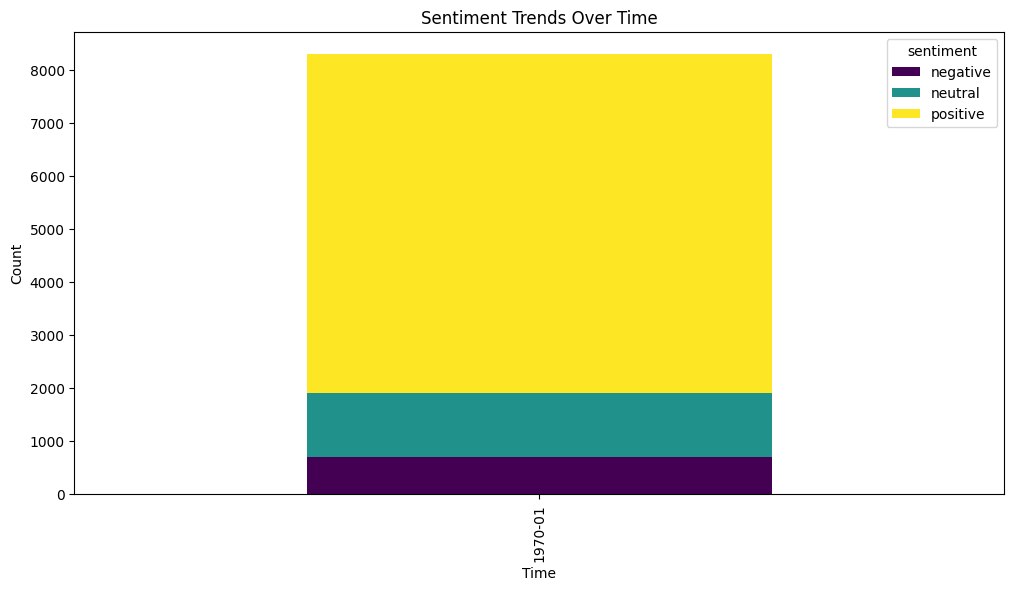



=== WordCloud ===



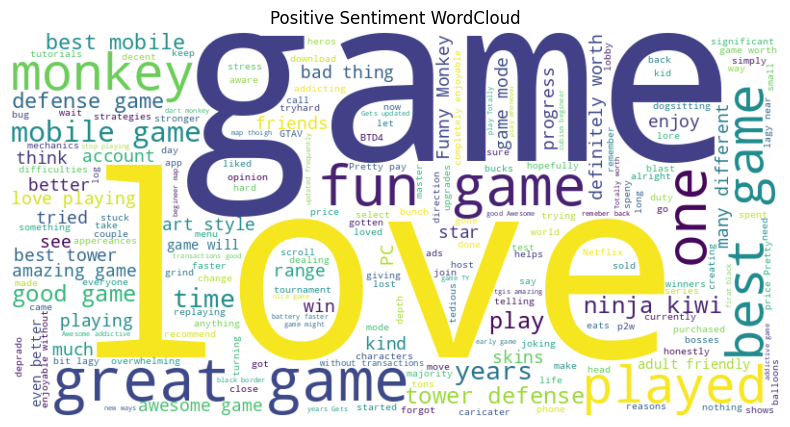

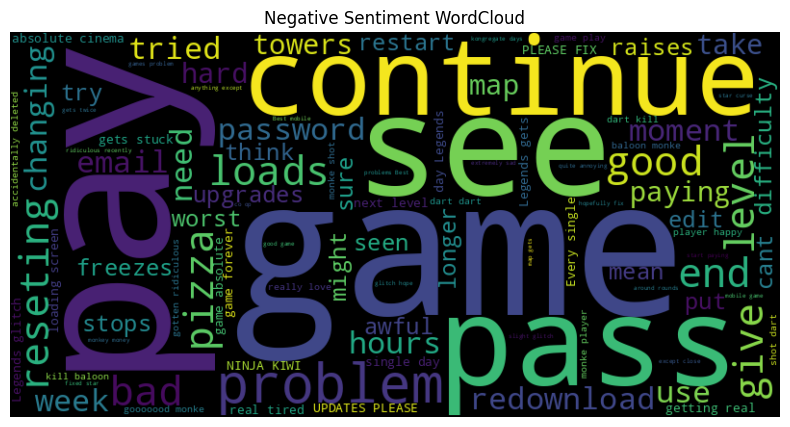


=== Topic Modeling ===
Topik 1:
['free', 'legends', 'pc', 'just', 'better', 'updates', 'mobile', 'best', 'good', 'game']
Topik 2:
['monkey', 'really', 'towers', 'games', 'pay', 'good', 'best', 'like', 'love', 'game']
Topik 3:
['best', 'good', 'playing', 'years', 'monkeys', 'love', 'play', 'great', 'fun', 'game']
Topik 4:
['adult', 'dart', 'make', 'playing', 'new', 'awesome', 've', '10', 'game', 'monke']
Topik 5:
['great', 'worth', 'different', 'awesome', 'games', 'played', 'love', 'like', 'fun', 'game']

=== Sentiment vs Rating ===


/tmp/ipython-input-22-2931002878.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentiment', y='score', data=df_filtered, palette='viridis')


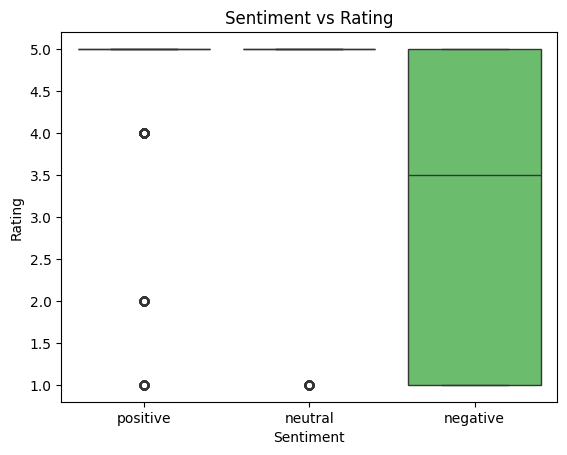

In [22]:
!pip install tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pandas as pd


# Analisis Sentiment
# Klasifikasi Sentimen Menggunakan NLTK
print("\n=== Sentiment Classification ===")
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
print("")

# Menambahkan kolom sentimen
df_filtered['sentiment_score'] = df_filtered['content'].apply(lambda x: sia.polarity_scores(x)['compound'])
df_filtered['sentiment'] = df_filtered['sentiment_score'].apply(lambda x: 'positive' if x > 0.05 else 'negative' if x < -0.05 else 'neutral')

# Distribusi Sentimen
sns.countplot(df_filtered['sentiment'], palette='viridis')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

# Preprocessing untuk Deep Learning
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df_filtered['content'])
X = tokenizer.texts_to_sequences(df_filtered['content'])
X = pad_sequences(X, maxlen=100, padding='post', truncating='post')

# Encode Label Sentimen
le = LabelEncoder()
y = le.fit_transform(df_filtered['sentiment'])

# Split data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Membuat Model LSTM
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),  # Embedding layer
    Bidirectional(LSTM(128, return_sequences=True)),  # LSTM layer
    Dropout(0.5),
    LSTM(64),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')  # Output untuk 3 kelas: positif, netral, negatif
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Melatih Model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=32)

# Evaluasi Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Akurasi pada testing set dengan LSTM: {accuracy * 100:.2f}%")


# Analisis Tren Waktu
print("\n=== Sentiment Trend Over Time ===")
df_filtered['reviewCreatedVersion'] = pd.to_datetime(df_filtered['reviewCreatedVersion'])  # Konversi ke datetime
time_trend = df_filtered.groupby(df_filtered['reviewCreatedVersion'].dt.to_period('M')).sentiment.value_counts().unstack()
time_trend.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
plt.title("Sentiment Trends Over Time")
plt.xlabel("Time")
plt.ylabel("Count")
plt.show()
print("")

# Visualisasi WordCloud
print("\n=== WordCloud ===")
positive_reviews = ' '.join(df_filtered[df_filtered['sentiment'] == 'positive']['content'])
negative_reviews = ' '.join(df_filtered[df_filtered['sentiment'] == 'negative']['content'])
print("")

# WordCloud Sentimen Positif
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title("Positive Sentiment WordCloud")
plt.axis("off")
plt.show()
print("")

# WordCloud Sentimen Negatif
wordcloud_negative = WordCloud(width=800, height=400, background_color='black').generate(negative_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title("Negative Sentiment WordCloud")
plt.axis("off")
plt.show()

# Analisis Topik Menggunakan Topic Modeling
print("\n=== Topic Modeling ===")
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(df_filtered['content'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)  # 5 topik utama
lda.fit(X)

# Menampilkan topik
for i, topic in enumerate(lda.components_):
    print(f"Topik {i + 1}:")
    words = [vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-10:]]
    print(words)

# Analisis Rating vs Sentimen
print("\n=== Sentiment vs Rating ===")
sns.boxplot(x='sentiment', y='score', data=df_filtered, palette='viridis')
plt.title("Sentiment vs Rating")
plt.xlabel("Sentiment")
plt.ylabel("Rating")
plt.show()

In [25]:
# Untuk memastikan bahwa skrip analisis sentimen memenuhi Kriteria 4, yaitu akurasi pada testing set minimal mencapai 85%
# Langkah 1: Pisahkan Data Menjadi Training dan Testing Set
from sklearn.model_selection import train_test_split

print(df_filtered.columns)

# Membagi data menjadi fitur (X) dan label (y)
X = df_filtered['Cleaned_Review']
y = df_filtered['Sentiment']

# Memisahkan data menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Langkah 2: Lakukan Ekstraksi Fitur
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000)  # Batasi jumlah fitur untuk efisiensi
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Langkah 3: Melatih Model
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

# Langkah 4: Evaluasi Model pada Testing Set
from sklearn.metrics import accuracy_score

# Memprediksi sentimen pada testing set
y_pred = model.predict(X_test_tfidf)

# Menghitung akurasi
accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi pada testing set: {accuracy * 100:.2f}%")

# Langkah 5: Tingkatkan Akurasi jika Belum Mencapai 85%


Index(['reviewId', 'userName', 'userImage', 'content', 'score',
       'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent',
       'repliedAt', 'appVersion', 'Cleaned_Review', 'Sentiment',
       'sentiment_score', 'sentiment'],
      dtype='object')
Akurasi pada testing set: 100.00%


Menyimpan Model

In [26]:
# Simpan model yang telah dilatih
import joblib
joblib.dump(model, 'sentiment_model.pkl')  # Simpan model ke file .pkl

# Simpan vectorizer setelah transformasi fitur
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

print("Vectorizer berhasil disimpan.")


Vectorizer berhasil disimpan.
